In [26]:
!python ../src/utils.py
%reload_ext autoreload

In [27]:
import os
import math
import ROOT as rt
import numpy as np
import matplotlib.pyplot as plt
import copy
import utils 
from ROOT import VecOps
from analysis import (df, df_filtered, tree, HMNCSBR, TRUNCSBR, COLOR_MAP)

name_tag = str(utils.TAG)
print("cwd:", os.getcwd())

cwd: /home/student/projects/optimizing_DEDx_estimator/notebooks


In [28]:
cluster = df.AsNumpy(["cluster_DeDxStrip"])["cluster_DeDxStrip"]
drawer = utils.HistogramDrawer()

**Input parameters I am working with now**
+ threshold
- seeds
* range fit
+ freedman_diaconis bins
- cluster
* track level h2 dedx calculator


__I should be able to return all the parameters I need to see the distribution (mpv, stddev, h2 mean) with a single parent loop__

__filter out the fits that did not converge or have pathalogical mpvs__

__check how strongly the fits tighten the mpv distributions__

Warning in <TFile::Append>: Replacing existing TH1: h_arith (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_h2 (Potential memory leak).


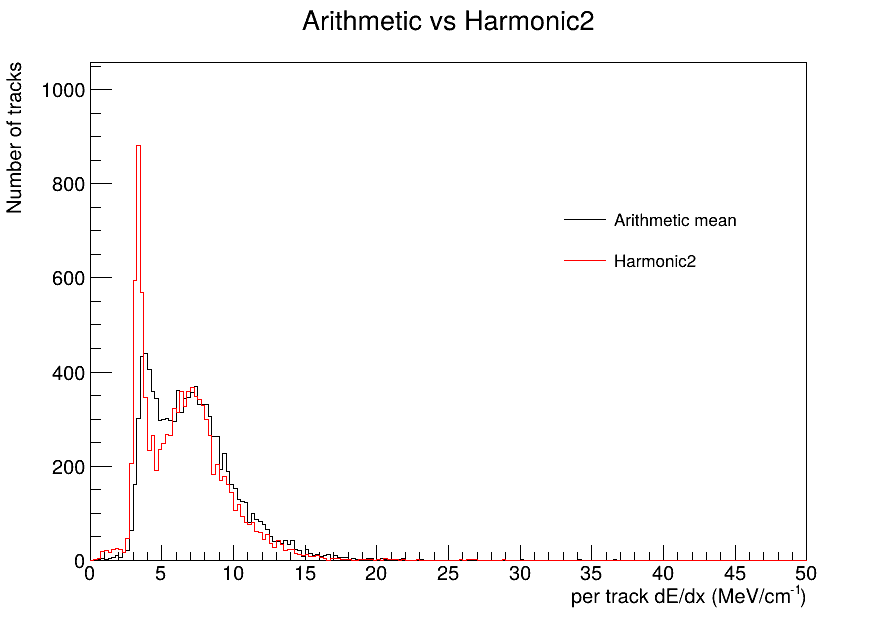

In [29]:

# ------------------------------------------------------------------
# 1.  Collect per‑track estimators  (fixed)
# ------------------------------------------------------------------
arith_vals = []     # arithmetic mean  (per track)
harm2_vals = []     # Harmonic‑2 (I_h) (per track)

for evt, tracks in zip(tree, cluster):           # evt  = ROOT entry
                                                 # tracks = List[List[float]]
    ih_vec = evt.DeDx_IhStrip                    # ROOT std::vector<double>

    for trk_idx, hit_list in enumerate(tracks):

        # ---------- Arithmetic mean ----------
        if hit_list:
            arith_vals.append(sum(hit_list) / len(hit_list))
        else:
            arith_vals.append(-1)

        # ---------- Harmonic‑2 (pre‑computed) ----------
        # Guard against events where #Ih values < #tracks
        if trk_idx < len(ih_vec):
            harm2_vals.append(float(ih_vec[trk_idx]))
        else:
            harm2_vals.append(-1)               # or np.nan if you prefer


arith_vals = np.asarray(arith_vals, dtype=float)
harm2_vals = np.asarray(harm2_vals, dtype=float)

# ------------------------------------------------------------------
# 2.  Build ROOT histograms (same range / binning)
# ------------------------------------------------------------------

nbins = 200                       

h_arith = rt.TH1F("h_arith",
                  "Arithmetic vs Harmonic2;per track dE/dx (MeV/cm^{-1});Number of tracks",
                  nbins, 0, 50)

h_h2    = rt.TH1F("h_h2",
                  "Arithmetic vs Harmonic2;per track dE/dx (MeV/cm^{-1});Number of tracks",
                  nbins, 0, 50)

for v in arith_vals: h_arith.Fill(v)
for v in harm2_vals: h_h2.Fill(v)
rt.gStyle.SetOptStat(0)  # Remove statistics box 

# ------------------------------------------------------------------
# 3.  Styling
# ------------------------------------------------------------------
h_arith.SetLineColor(rt.kBlack)


h_h2.SetLineColor(rt.kRed)

overall_max = max(h_arith.GetMaximum(), h_h2.GetMaximum())

h_arith.SetMaximum(overall_max * 1.2) 
# ------------------------------------------------------------------
# 4.  Draw on the same canvas
# ------------------------------------------------------------------
c = rt.TCanvas("c", "Arithmetic vs Harmonic2", 900, 650)
h_arith.Draw("hist")
h_h2.Draw("hist SAME")

leg = rt.TLegend(0.62, 0.55, 0.88, 0.68)
leg.AddEntry(h_arith, "Arithmetic mean", "l")
leg.AddEntry(h_h2,   "Harmonic2", "l")
leg.SetBorderSize(0)
leg.SetFillStyle(0)
leg.Draw()

# c.SetLogy()   # optional, reveals Landau tails more clearly
c.Update()
# c.SaveAs("dedx_mean_comparison.png")   # or .pdf/.root


In [30]:
# drawer.save(c, f"{utils.PLOTS_DIR}/arithmetric vs h2",["png"])

In [31]:

results = utils.fit_mpv(cluster)

Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 
Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 
Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 
Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 
Error in <Minuit2>: VariableMetricBuilder Initial matrix not pos.def.
Error in <Minuit2>: VariableMetricBuilder Initial matrix not pos.def.
Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 
Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 
Error in <Minuit2>: VariableMetricBuilder Initial matrix not pos.def.
Error in <

In [32]:
neg_tracks = results["neg_tracks"]
neg_track_labels = results["neg_mpvs"]


print(len(neg_tracks))

for label, track in zip(neg_track_labels, neg_tracks):
  print(f"{label} : {track}")

18
Event 36888 Trk 2 : { 2.87084f, 7.24237f, 6.13317f, 10.3733f, 18.6288f, 136.122f }
Event 37009 Trk 1 : { 3.93640f, 6.40171f, 3.93247f, 3.06810f, 3.73513f, 2.05625f, 2.60408f, 59.3439f }
Event 37077 Trk 1 : { 7.23092f, 3.21012f, 3.43804f, 99.2167f, 7.71873f, 0.972959f }
Event 37658 Trk 5 : { 3.92032f, 9.37611f, 70.5981f, 4.60633f, 2.58087f, 2.54820f, 3.98561f, 2.05819f }
Event 42271 Trk 0 : { 7.37285f, 3.14832f, 3.37351f, 82.5019f, 2.60977f, 2.95203f }
Event 42577 Trk 0 : { 7.71427f, 7.27343f, 168.580f, 12.7205f, 8.81630f, 6.51776f, 5.73063f, 7.74582f, 6.12025f, 8.00448f, 6.17840f, 6.74174f, 6.46979f, 4.83757f, 4.48795f, 6.70362f }
Event 43057 Trk 4 : { 3.15743f, 3.43331f, 4.28202f, 9.58706f, 2.82304f, 3.58343f, 2.14246f, 3.52100f, 76.7960f }
Event 43106 Trk 0 : { 2.55813f, 2.74532f, 3.77468f, 2.71405f, 4.86658f, 3.15082f, 2.68290f, 3.83715f, 3.05725f, 3.02199f, 4.60036f, 3.08001f, 63.1572f, 6.19792f, 5.65915f, 3.15677f, 2.88726f }
Event 43249 Trk 2 : { 19.8500f, 16.0639f, 7.21180f, 

In [33]:
labels = neg_track_labels

desired_branches = [
    "DeDx_IhStrip",
    "IsoTrack_pt",
    "IsoTrack_eta",
    "IsoTrack_isHighPurityTrack"
]

# first call builds the cache
vals, evt_cache = utils.get_attrs_for_labels(tree, labels, desired_branches)

# # later calls reuse the same cache (fast!)
# more_vals, _ = get_attrs_for_labels(tree, other_labels, desired_branches, evt_cache)

# precalc_vals = vals 
temp = vals
loop_vals = copy.deepcopy(vals)
# precalc_vals = temp
# inspect:
for lbl, d in vals.items():
    print(lbl)
    for k, v in d.items():
        print(f"  {k:20} = {v}")


Event 36888 Trk 2
  DeDx_IhStrip         = 5.786173343658447
  IsoTrack_pt          = 78.0517056452733
  IsoTrack_eta         = -2.381635640287952
  IsoTrack_isHighPurityTrack = False
Event 37009 Trk 1
  DeDx_IhStrip         = 3.3431618213653564
  IsoTrack_pt          = 64.96723705191845
  IsoTrack_eta         = -0.40910814377098254
  IsoTrack_isHighPurityTrack = True
Event 37077 Trk 1
  DeDx_IhStrip         = 2.170145034790039
  IsoTrack_pt          = 46.331066734509655
  IsoTrack_eta         = 2.228930827939327
  IsoTrack_isHighPurityTrack = False
Event 37658 Trk 5
  DeDx_IhStrip         = 3.3174257278442383
  IsoTrack_pt          = 227.7040542874987
  IsoTrack_eta         = -2.4237440713764067
  IsoTrack_isHighPurityTrack = False
Event 42271 Trk 0
  DeDx_IhStrip         = 3.5772249698638916
  IsoTrack_pt          = 286.1144550523513
  IsoTrack_eta         = -0.9950261646287566
  IsoTrack_isHighPurityTrack = False
Event 42577 Trk 0
  DeDx_IhStrip         = 6.718465328216553
  IsoTrac

In [34]:
# assert loop_vals is not precalc_vals

In [35]:
# labels = loop_vals.keys() & precalc_vals.keys()  # intersection

# same = all(
#     utils.records_equal(loop_vals[lbl], precalc_vals[lbl])
#     for lbl in labels
# )

# print("All identical:", same)


In [36]:
def plot_track_distributions(tracks, labels=None):
    """
    tracks : list of sequences of hit-values
    labels : optional list of titles for each track
    bins   : histogram bin count
    """
    for i, track in enumerate(tracks):
        # Freedman–Diaconis binning
        nbins, lo, hi = utils.freedman_diaconis_bins(track)
        plt.figure()
        plt.hist(track, bins=nbins, range=(lo, hi))
        bw = (hi - lo)/nbins
        title = labels[i] if labels is not None else f"Track #{i}"
        plt.title(title)
        plt.xlabel("dE/dx")
        plt.ylabel(f"hits / {bw:.2f}")
        plt.tight_layout()
        plt.show()


In [37]:


def plot_track_distributions_pyroot(tracks, labels=None, cols=2, canvas_name="c_tracks"):
    """
    tracks      : list of sequences of hit-values
    labels      : optional list of strings, one per track
    cols        : number of columns in the canvas grid
    canvas_name : name/title for the TCanvas
    
    Returns (canvas, histo_list) where histo_list is a list of (TH1F, TF1) tuples.
    """
    N    = len(tracks)
    rows = math.ceil(N / cols)
    c    = rt.TCanvas(canvas_name, canvas_name, cols*800, rows*800)
    c.Divide(cols, rows)
    
    results = []
    for i, track in enumerate(tracks):
        pad = c.cd(i+1)
        
        # Freedman–Diaconis binning
        nbins, lo, hi = utils.freedman_diaconis_bins(track)
        title         = labels[i] if labels else f"Track {i}"
        
        # make & fill histogram
        h = rt.TH1F(f"h_{i}", title, nbins, lo, hi)
        for x in track:
            h.Fill(x)
        
        # style axes
        bw = (hi - lo) / nbins
        h.GetXaxis().SetTitle("dE/dx (MeV/cm)")
        h.GetYaxis().SetTitle(f"Entries/{bw:.2f}")
        h.SetStats(False)
        
        # draw hits
        h.Draw()
        
        # fit a Landau
        f = rt.TF1(f"f_{i}", "landau", lo, hi)
        mpv0, amp0, sig0 = utils.seeds(h)
        f.SetParameters(amp0, mpv0, sig0)
        f.SetParLimits(1, lo, hi)
        f.SetParLimits(2, 0.05, hi - lo)
        h.Fit(f, "RQ")  
        
        # draw fit on top
        f.SetLineColor(rt.kRed)
        f.Draw("same")
        
        results.append((h, f))
    
    c.Update()
    return c, results


In [38]:
# canvas, histo_fits = plot_track_distributions_pyroot(
#     neg_tracks,
#     labels=neg_track_labels,
#     cols=2,
#     canvas_name="c_bad_mpv_tracks",
# )
# canvas.Draw()

In [39]:
# drawer.save(canvas, f"{utils.PLOTS_DIR}/fitted_bad_tracks",["png"])

In [40]:
# plot_track_distributions(neg_tracks, labels=neg_track_labels)

Warning in <TFile::Append>: Replacing existing TH1: corr (Potential memory leak).


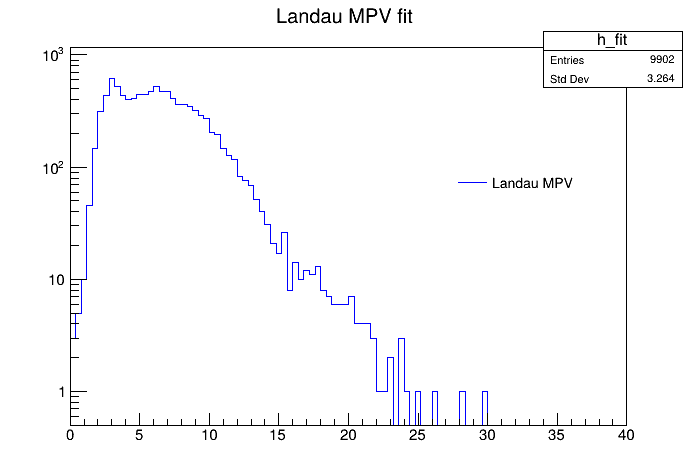

In [41]:

corel_params = results["corel"]


c = rt.TCanvas()

x_vals = [r[0] for r in corel_params]
y_vals = [r[1] for r in corel_params]
corr_hist = rt.TH2F("corr", "MPV vs Harmonic Mean;MPV;Harmonic2", 50, min(x_vals), max(x_vals), 50, min(y_vals), max(y_vals))
for x, y in corel_params:
    corr_hist.Fill(x, y)
rt.gStyle.SetOptStat("neiuor")
corr_hist.Draw("COLZ")


xmin, xmax = min(x_vals), max(x_vals)
ymin, ymax = min(y_vals), max(y_vals)


low  = max(xmin, ymin)
high = min(xmax, ymax)

diag = rt.TLine(low, low, high, high)   # y = x
diag.SetLineColor(rt.kRed)
diag.SetLineWidth(2)
diag.Draw("same")

c.Draw()

Warning in <TFile::Append>: Replacing existing TH1: h_fit (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_h2 (Potential memory leak).


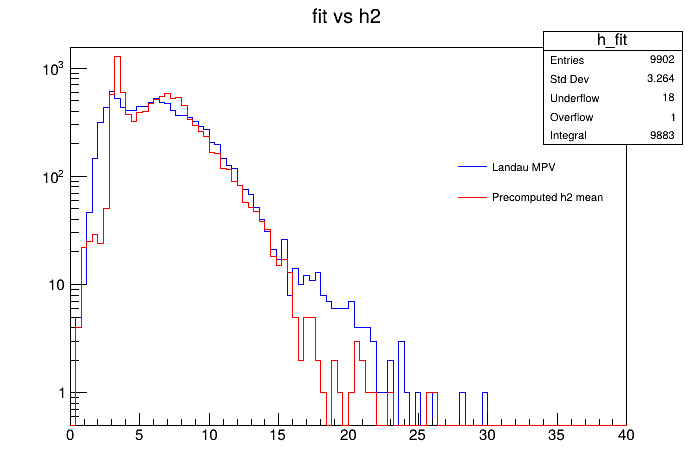

In [42]:
c = rt.TCanvas()
c.SetLogy()
# N = len(corel_params)
hist_mpv = rt.TH1F("h_fit", "fit vs h2", 100, 0, 40)
hist_h2 = rt.TH1F("h_h2", "fit vs h2",100, 0, 40)


for mpv, h2 in corel_params:
  hist_mpv.Fill(mpv)
  hist_h2.Fill(h2)

hist_mpv.SetLineColor(rt.kBlue)
hist_h2.SetLineColor(rt.kRed)
max1 = hist_mpv.GetMaximum()
max2 = hist_h2.GetMaximum()
overall_max = max(max1, max2)
hist_mpv.SetMaximum(overall_max * 1.2)

hist_mpv.Draw()
hist_h2.Draw("same")

leg = rt.TLegend(0.65, 0.55, 0.88, 0.68)  # x1,y1,x2,y2 in NDC
leg.SetBorderSize(0)
leg.SetFillStyle(0)
leg.AddEntry(hist_mpv, "Landau MPV", "l")
leg.AddEntry(hist_h2,  "Precomputed h2 mean", "l")
leg.Draw()

c.Draw()

In [43]:
c = rt.TCanvas()
c.SetLogy()
# N = len(corel_params)
hist_mpv = rt.TH1F("h_fit", "Landau MPV fit", 100, 0, 40)



for mpv, h2 in corel_params:
  hist_mpv.Fill(mpv)


hist_mpv.SetLineColor(rt.kBlue)

# Enable statistics box with entries and standard deviation
rt.gStyle.SetOptStat("ner")  # n=entries, e=RMS/standard deviation, r=RMS

hist_mpv.Draw()


leg = rt.TLegend(0.65, 0.55, 0.88, 0.68)  # x1,y1,x2,y2 in NDC
leg.SetBorderSize(0)
leg.SetFillStyle(0)
leg.AddEntry(hist_mpv, "Landau MPV", "l")

leg.Draw()

c.Draw()

Warning in <TFile::Append>: Replacing existing TH1: h_fit (Potential memory leak).


In [44]:
# drawer.save(c, f"{utils.PLOTS_DIR}/landau_mpv_fitting",["png"])

In [45]:
fit_tot = hist_mpv.Integral(0, -1)
h2_tot = hist_h2.Integral(0, -1)

print(f"fit histogram integral: {fit_tot}\nh2 histogram integral: {h2_tot} ")

fit histogram integral: 9902.0
h2 histogram integral: 9902.0 


In [46]:
import pandas as pd
print(type(df))


<class cppyy.gbl.ROOT.RDataFrame at 0x616d536486c0>


In [47]:
# rdf_sel = utils.apply_sequential_filters(df)

In [48]:
# drawer.save(c, f"{utils.PLOTS_DIR}/fit_vs_h2(used_precalculated_h2_vals_logy)",["png"])

In [49]:
#generate a number of landau fit with known mpvs, use the datasets that make up the landau fits to calculate the harmonic2. check the corelation of the two 
#understand why we still get negative values
# and what makes up the outliers

In [50]:
# # c = rt.TCanvas()
# stack = utils.write_stacked_histos("fits", hists, "some tracks fitted with the landau", c)